In [51]:
import sys
import os
import time
import numpy as np
from core.gateway import Gateway
from examples.algorithms import BuyTheBid, Pegged
from datetime import datetime

### TEST BUY THE BID ALGORITHM
We are going to simulate a simple Buy The Bid algorithm. This algorithm just places orders at the best bid and replenishes them when they are filled or modify them when they are no longer in the best bid of the market.

We encapsulate the simulation inside a function to be able to run it with different latencies to check the effect of it in our total traded volume and price

Each simulation will process each of the more than 270k orders of Santander on that trading session, plus the effect of all the orders that our algorithm introduces in the market. Luckily, its quite fast, so we can run the whole simulation in a few seconds.

In [52]:
def sim_algo_with_latency(latency):
    gtw_kwargs = {
        'date': '2019-05-23',
        'ticker': 'san',
        'start_h': 9,
        'end_h': 17.5,
        'latency': latency,
    }

    # Init the Gateway and its Orderbook
    gtw = Gateway(**gtw_kwargs)
    # Instaciate the algorithm
    btb = BuyTheBid(10_00_000, 100)
    
    # While the algo is not done (has not traded all the volume)
    # and the simulation end time is not reached
    while (not btb.done) and (gtw.ob_time < gtw.end_time):            
        # Eval the algo with every change in the market
        btb.eval_and_act(gtw)
        # Move the market one tick, that is, introduce the next order (historical or ours)
        # and return back
        gtw.tick()    
        
        # We return the total traded volume achieved by the algo and the VWAP obtained
    return [latency, gtw.ob.my_cumvol, gtw.ob.my_vwap]


In [53]:
results=[]
for latency in [10**x for x in range(8)]:
    results.append(sim_algo_with_latency(latency=latency))
    

In [54]:
import pandas as pd
df_res = pd.DataFrame(results,columns=['latency', 'traded_vol', 'vwap'])
print(df_res)

    latency  traded_vol      vwap
0         1      380288  4.021676
1        10      380288  4.021676
2       100      380288  4.021676
3      1000      366945  4.021825
4     10000      326673  4.021844
5    100000      275226  4.021876
6   1000000      230076  4.021909
7  10000000      114747  4.022236


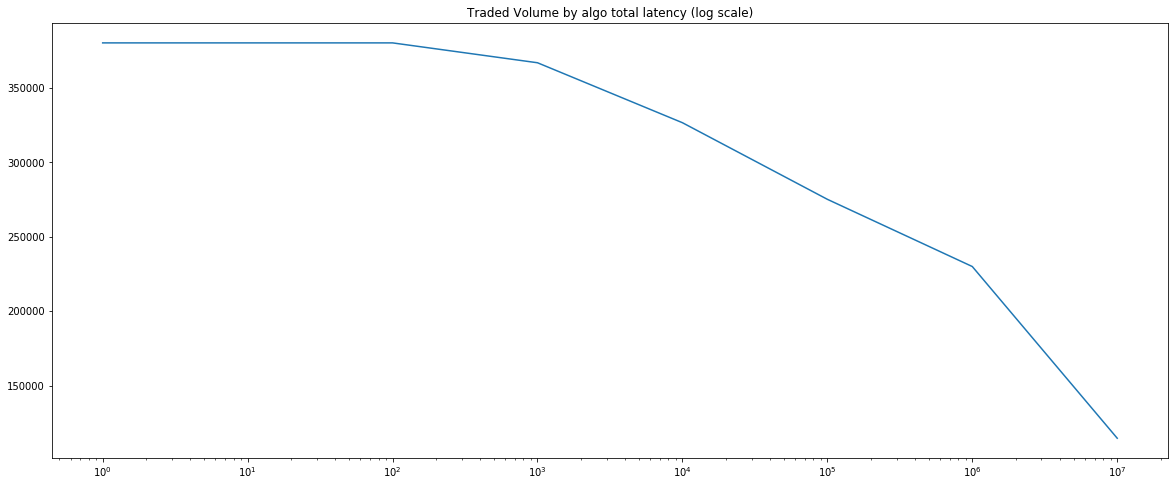

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.title('Traded Volume by algo total latency (log scale)')
plt.semilogx(df_res.latency, df_res.traded_vol)
plt.show()

We can observe that up to 100 microseconds, there is no effect on latency. Lets zoom in the range between 100 micros and 10 miliseconds to see the effect. This will be 100 simulations of a full trading session, it will take around 5 minutes to complete.

In [56]:
results=[]
for latency in np.arange(100, 10_000, 100):
    results.append(sim_algo_with_latency(latency=int(latency)))

In [57]:
import pandas as pd
df_res = pd.DataFrame(results,columns=['latency', 'traded_vol', 'vwap'])

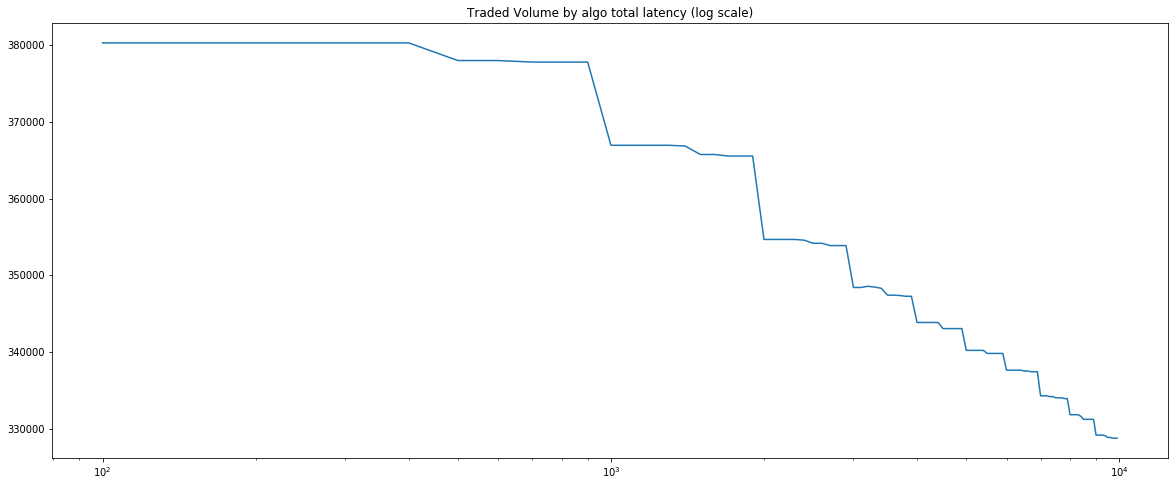

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.title('Traded Volume by algo total latency (log scale)')
plt.semilogx(df_res.latency, df_res.traded_vol)
plt.show()

This is very interesting!!